In [1]:
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

In [2]:
matrix = pd.read_csv('/home/bram/bramenv/aa_test_2 matrix/training_set_final.csv')

# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']]

print(X_data)
print(y_data_pre)

print(X_data)
print(y_data_pre)
assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

# X_data=X_data.sample(frac=1, random_state=2023)
y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y = y_data_pre['annot']
print(y)

X_data=X_data.drop(['annot'], axis=1)
X=X_data.drop(['BDSPPatientID', 'CreateDate', 'hospital'], axis=1) #dopamine and dopamineagonist?
print(X)


      BDSPPatientID  CreateDate hospital  parkinson disease_pos  pd_pos  \
0         115418423  2022-08-02      MGB                      0       0   
1         115999654  2021-01-02      MGB                      0       0   
2         177513327  2016-05-26      STF                      0       0   
3         119646649  2019-08-02      MGB                      0       0   
4         151270446  2018-11-27    BIDMC                      1       0   
...             ...         ...      ...                    ...     ...   
1909      118500543  2020-09-19      MGB                      0       0   
1910      116178066  2020-11-08      MGB                      1       0   
1911      116687633  2017-03-30      MGB                      1       0   
1912      177538617  2017-09-19      STF                      0       0   
1913      112882252  2022-01-19      MGB                      0       0   

      parkinson_pos  parkinsonismx_pos  disease_pos  akathisia_pos  \
0                 0          

In [19]:
print(matrix)

      BDSPPatientID  CreateDate hospital  parkinson disease_pos  pd_pos  \
0         115418423  2022-08-02      MGB                      0       0   
1         115999654  2021-01-02      MGB                      0       0   
2         177513327  2016-05-26      STF                      0       0   
3         119646649  2019-08-02      MGB                      0       0   
4         151270446  2018-11-27    BIDMC                      1       0   
...             ...         ...      ...                    ...     ...   
1909      118500543  2020-09-19      MGB                      0       0   
1910      116178066  2020-11-08      MGB                      1       0   
1911      116687633  2017-03-30      MGB                      1       0   
1912      177538617  2017-09-19      STF                      0       0   
1913      112882252  2022-01-19      MGB                      0       0   

      parkinson_pos  parkinsonismx_pos  disease_pos  akathisia_pos  \
0                 0          

In [3]:
x_columns=list(X.columns)
print(x_columns)

['parkinson disease_pos', 'pd_pos', 'parkinson_pos', 'parkinsonismx_pos', 'disease_pos', 'akathisia_pos', 'anosmia_pos', 'apraxia_pos', 'autonomic_pos', 'axial_pos', 'basophilic_pos', 'bradyphrenia_pos', 'cholinergic_pos', 'cogwheel_pos', 'cognitive impairment_pos', 'denervation_pos', 'dopamine_pos', 'dopamine agonist_pos', 'dysphagia_pos', 'dysphonia_pos', 'dystonia_pos', 'facial_pos', 'fasciculation_pos', 'gait_pos', 'festinating_pos', 'shuffling_pos', 'freezing_pos', 'hyposmia_pos', 'hyperreflexia_pos', 'hypokinetic_pos', 'hypomimia_pos', 'hypophonia_pos', 'idiopathic_pos', 'imaging_pos', 'dat_pos', 'mri_pos', 'scan_pos', 'masked facies_pos', 'micrographia_pos', 'mild cognitive impairment_pos', 'mci_pos', 'moca_pos', 'movement disorder_pos', 'multiple system atrophy_pos', 'msa_pos', 'occupational therapy_pos', 'orthostatic_pos', 'palliative_pos', 'paratonia_pos', 'pathology_pos', 'pet_pos', 'physical therapy_pos', 'posture_pos', 'prodrome_pos', 'progressive supranuclear palsy_pos', 

In [4]:
# # X_data = pd.read_csv('/home/bram/bramenv/matrices/finalmatrix.csv')
# print(X_data.columns)
# print(X_data.head())
# X=X_data.drop(['BDSPPatientID', 'CreateDate', 'hospital', 'parkinsonism'], axis=1)
# print(X.head())
# # y_data_pre = pd.read_csv('/home/bram/bramenv/matrices/full_annotations_ordered2.csv')
# y_data = y_data_pre[['BDSPPatientID', 'annot']]
# y = y_data_pre['annot']
# print(y)


In [5]:
print(X.head())
print(y.head())

   parkinson disease_pos  pd_pos  parkinson_pos  parkinsonismx_pos  \
0                      0       0              0                  0   
1                      0       0              0                  0   
2                      0       0              0                  0   
3                      0       0              1                  1   
4                      1       0              1                  0   

   disease_pos  akathisia_pos  anosmia_pos  apraxia_pos  autonomic_pos  \
0            0              0            0            0              0   
1            0              0            0            0              0   
2            0              0            0            0              0   
3            1              0            0            0              0   
4            1              0            0            0              0   

   axial_pos  ...  Ongentys  Nourianz  RequipXL  Apokyn  Zydis  Tasmar  COMT  \
0          0  ...         0         0         0       

In [6]:
from collections import Counter
print(Counter(y))  # Counts the occurrences of each class in the target variable


Counter({0: 1479, 1: 435})


In [7]:
# Lists to store false positive and false negative patient IDs
false_positives = []
false_negatives = []
patient_ids = y_data_pre['BDSPPatientID']

In [8]:

all_predictions_nonbin=[]
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in X.columns}

fold_patient_ids = {f'fold_{i+1}': {'train': [], 'test': []} for i in range(10)}

# Initialize KFold
gkf = GroupKFold(n_splits=10)
 

for cvi, (train_index, test_index) in enumerate(gkf.split(X,y,groups=y_data_pre['BDSPPatientID'])): #to link patientid to cv fold number
# for train_index, test_index in gkf.split(X,y,groups=y_data_pre['BDSPPatientID']):
    Xtr, Xte = X.loc[train_index], X.loc[test_index]
    ytr, yte = y.loc[train_index], y.loc[test_index]

   # Store patient IDs
    fold_patient_ids[f'fold_{cvi+1}']['train'].extend(y_data_pre.loc[train_index, 'BDSPPatientID'].tolist())
    fold_patient_ids[f'fold_{cvi+1}']['test'].extend(y_data_pre.loc[test_index, 'BDSPPatientID'].tolist())
   
    model = LogisticRegression(
            penalty='elasticnet',
            class_weight=None, random_state=2023,
            solver='saga', max_iter=10000)
   
    search_spaces = {
         'C': (1e-4, 1e+4, 'log-uniform'),  # adjusted this from 2 to 4
         'l1_ratio': (0.01, 0.99),
    }
    model_cv = BayesSearchCV(model,
            search_spaces,
            n_iter=50, scoring='roc_auc', n_jobs=23,
            cv=10, random_state=2023)
    model_cv.fit(Xtr, ytr)

    #Find the Best hyperparameters and append them
    best_hparams = model_cv.best_params_
    best_C = best_hparams['C']
    best_l1_ratio = best_hparams['l1_ratio']
    final_Cs.append(best_C)
    final_l1.append(best_l1_ratio)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:,1]      # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
    yte_pred = model.predict_proba(Xte)[:,1]    # Xte is testing features

    fpr, tpr, cutoffs = roc_curve(ytr, ytr_pred) # changed this one to training
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]  # get best cut off from training set
    yte_pred_bin =(yte_pred>best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append( f1_score(yte, yte_pred_bin) )
    cf_cv.append( confusion_matrix(yte, yte_pred_bin) )
    predictions.append(yte_pred_bin)

    model_filename = f'model_train_allhospitals_Notes+ICD+Med_fold{cvi+1}.pickle'
    with open(model_filename, 'wb') as f:
        pickle.dump({'model':model, 'cutoff':best_cutoff}, f)

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred) # repeat to get the fpr and tpr from testing set

    # Store the predictions and true labels for this fold
    all_predictions_nonbin.extend(yte_pred)
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances (coefficients)
    feature_importances = model.coef_[0]
    for feature, importance in zip(X.columns, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)
fold_patient_ids_list = []
for fold, ids in fold_patient_ids.items():
    for train_id in ids['train']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'train', 'patient_id': train_id})
    for test_id in ids['test']:
        fold_patient_ids_list.append({'fold': fold, 'type': 'test', 'patient_id': test_id})
fold_patient_ids_df = pd.DataFrame(fold_patient_ids_list)
fold_patient_ids_df.to_csv('fold_patient_ids.csv', index=False)

all_true_labels = pd.Series(all_true_labels)
all_predictions = pd.Series(all_predictions)

false_positive_ids = patient_ids[(all_true_labels == 0) & (all_predictions == 1)]
false_negative_ids = patient_ids[(all_true_labels == 1) & (all_predictions == 0)]
false_positives.append(false_positive_ids)
false_negatives.append(false_negative_ids)
# Save false positives and false negatives to CSV files
false_positives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fp) for fp in false_positives]), 'BDSPPatientID': np.concatenate(false_positives)})
false_negatives_df = pd.DataFrame({'Fold': np.repeat(range(1), [len(fn) for fn in false_negatives]), 'BDSPPatientID': np.concatenate(false_negatives)})

false_positives_df.to_csv('false_positives.csv', index=False)
false_negatives_df.to_csv('false_negatives.csv', index=False)

Feature importances for this fold:
                   Feature  Importance
2            parkinson_pos    3.470367
208                    ICD    1.442705
0    parkinson disease_pos    1.149355
1                   pd_pos    0.834545
210              Carbidopa    0.482558
..                     ...         ...
20            dystonia_pos   -0.238924
35                 mri_pos   -0.345399
72              nausea_pos   -0.356934
3        parkinsonismx_pos   -0.430675
173             tremor_neg   -0.441043

[255 rows x 2 columns]
[0.9769919913126103]
[0.9292272011010614]
Feature importances for this fold:
                   Feature  Importance
2            parkinson_pos    3.968300
208                    ICD    1.422875
1                   pd_pos    1.020908
210              Carbidopa    0.876815
0    parkinson disease_pos    0.800327
..                     ...         ...
64            rigidity_pos   -0.166921
3        parkinsonismx_pos   -0.336639
35                 mri_pos   -0.412951
72    

In [9]:
print(np.mean(auc_cv)) 
print(np.mean(auc_pr))


0.9808508111212946
0.938000479501363


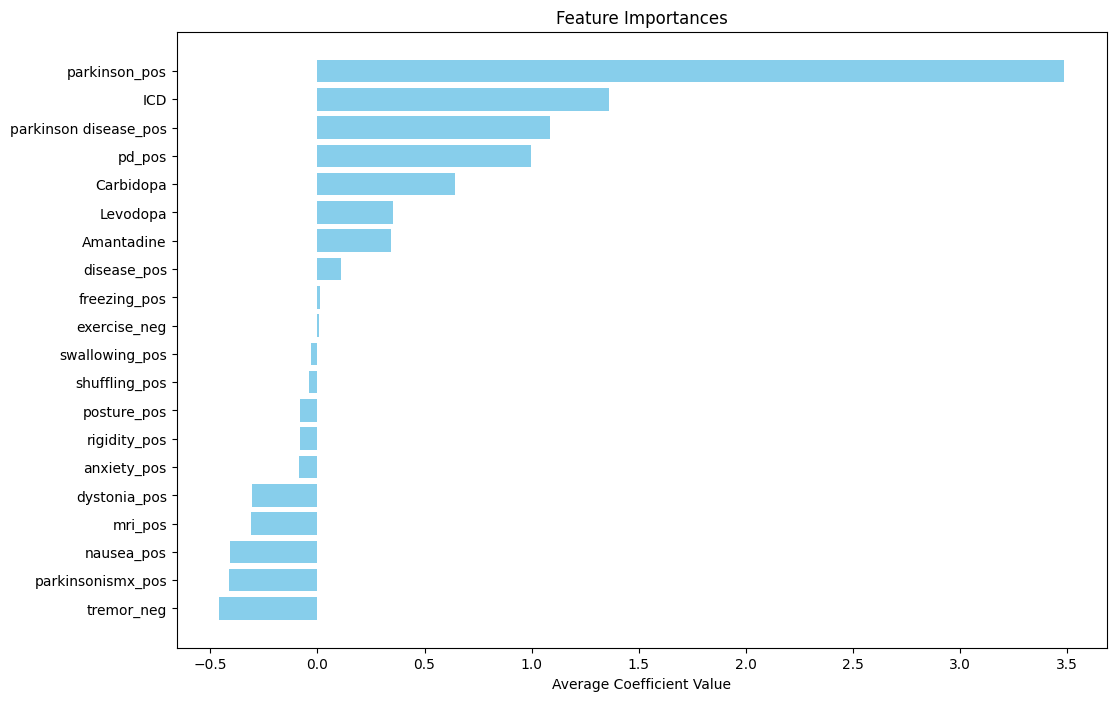

<Figure size 640x480 with 0 Axes>

In [10]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Save the DataFrame to a CSV file
feature_importance_df.to_csv('feat_importances.csv', index=False)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

plt.savefig('feat_importances.png')

In [11]:
print(plot_features)

('parkinson_pos', 'ICD', 'parkinson disease_pos', 'pd_pos', 'Carbidopa', 'Levodopa', 'Amantadine', 'disease_pos', 'freezing_pos', 'exercise_neg', 'swallowing_pos', 'shuffling_pos', 'posture_pos', 'rigidity_pos', 'anxiety_pos', 'dystonia_pos', 'mri_pos', 'nausea_pos', 'parkinsonismx_pos', 'tremor_neg')


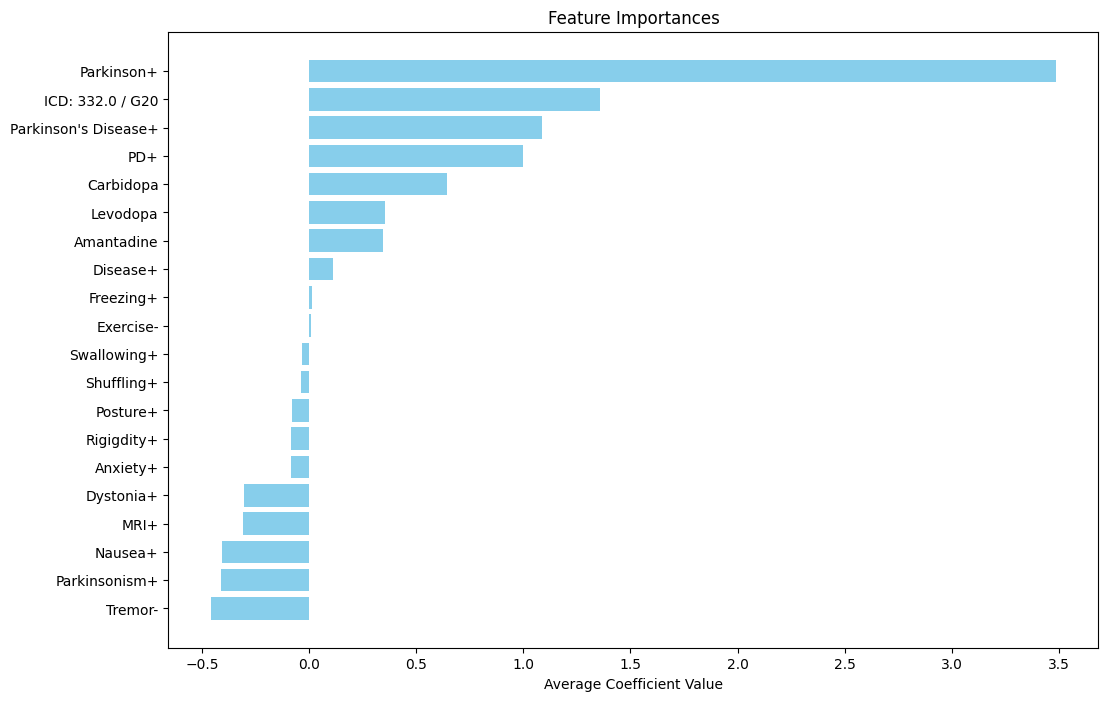

In [20]:
# before running this check for keywords
# Define custom feature names
custom_plot_features = [
    "Parkinson+", "ICD: 332.0 / G20","Parkinson's Disease+", "PD+","Carbidopa","Levodopa",  
    "Amantadine", "Disease+",
    "Freezing+","Exercise-", "Swallowing+", 'Shuffling+', "Posture+", "Rigigdity+","Anxiety+", 
    "Dystonia+","MRI+",
     "Nausea+",  "Parkinsonism+","Tremor-"
]

# Ensure the length of custom features matches the length of plot_features
assert len(custom_plot_features) == len(plot_features), "The number of custom features must match the number of plot features."

# Plot feature importances
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(plot_features)), plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# Set custom y-axis labels
plt.yticks(range(len(plot_features)), custom_plot_features)

# Display the plot
plt.show()


In [13]:
cf_cv

[array([[125,  14],
        [  1,  52]]),
 array([[146,   9],
        [  1,  36]]),
 array([[143,   7],
        [  1,  41]]),
 array([[137,  12],
        [  0,  43]]),
 array([[139,  10],
        [  1,  41]]),
 array([[142,   8],
        [  3,  38]]),
 array([[146,   6],
        [  2,  37]]),
 array([[132,  18],
        [  2,  39]]),
 array([[137,   9],
        [  3,  42]]),
 array([[128,  11],
        [  3,  49]])]

In [14]:
for fold_index, cf_matrix in enumerate(cf_cv):
    print(f"Confusion Matrix for Fold {fold_index + 1}:\n{cf_matrix}\n")


Confusion Matrix for Fold 1:
[[125  14]
 [  1  52]]

Confusion Matrix for Fold 2:
[[146   9]
 [  1  36]]

Confusion Matrix for Fold 3:
[[143   7]
 [  1  41]]

Confusion Matrix for Fold 4:
[[137  12]
 [  0  43]]

Confusion Matrix for Fold 5:
[[139  10]
 [  1  41]]

Confusion Matrix for Fold 6:
[[142   8]
 [  3  38]]

Confusion Matrix for Fold 7:
[[146   6]
 [  2  37]]

Confusion Matrix for Fold 8:
[[132  18]
 [  2  39]]

Confusion Matrix for Fold 9:
[[137   9]
 [  3  42]]

Confusion Matrix for Fold 10:
[[128  11]
 [  3  49]]



In [15]:

# Sum all confusion matrices to get overall counts
overall_cf_matrix = np.sum(cf_cv, axis=0)
print("Overall Confusion Matrix:\n", overall_cf_matrix)


Overall Confusion Matrix:
 [[1375  104]
 [  17  418]]


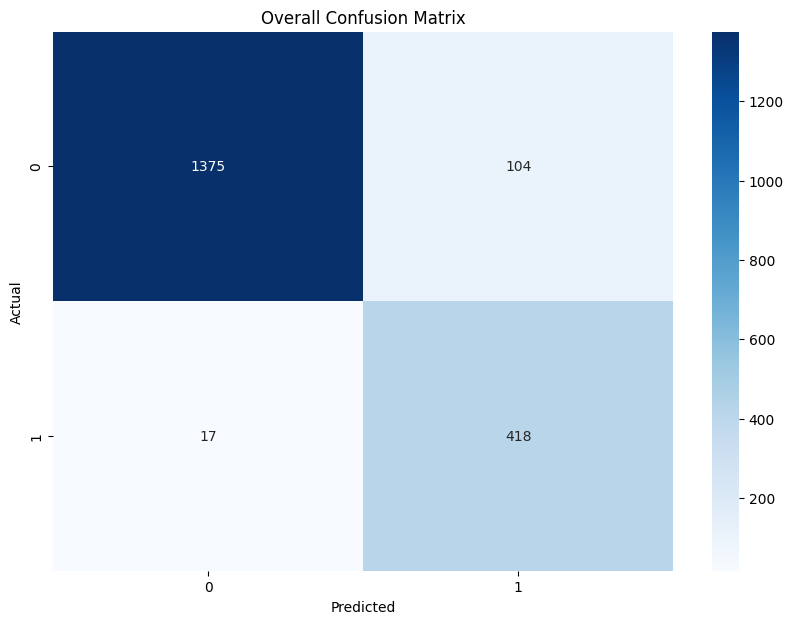

In [16]:
import seaborn as sns
# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(overall_cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the figure
plt.savefig('overall_confusion_matrix.png')

# Show the figure
plt.show()


In [17]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")


Metrics for Fold 1:
Accuracy: 0.9219
Precision: 0.7879
Recall: 0.9811
F1 Score: 0.8739

Metrics for Fold 2:
Accuracy: 0.9479
Precision: 0.8000
Recall: 0.9730
F1 Score: 0.8780

Metrics for Fold 3:
Accuracy: 0.9583
Precision: 0.8542
Recall: 0.9762
F1 Score: 0.9111

Metrics for Fold 4:
Accuracy: 0.9375
Precision: 0.7818
Recall: 1.0000
F1 Score: 0.8776

Metrics for Fold 5:
Accuracy: 0.9424
Precision: 0.8039
Recall: 0.9762
F1 Score: 0.8817

Metrics for Fold 6:
Accuracy: 0.9424
Precision: 0.8261
Recall: 0.9268
F1 Score: 0.8736

Metrics for Fold 7:
Accuracy: 0.9581
Precision: 0.8605
Recall: 0.9487
F1 Score: 0.9024

Metrics for Fold 8:
Accuracy: 0.8953
Precision: 0.6842
Recall: 0.9512
F1 Score: 0.7959

Metrics for Fold 9:
Accuracy: 0.9372
Precision: 0.8235
Recall: 0.9333
F1 Score: 0.8750

Metrics for Fold 10:
Accuracy: 0.9267
Precision: 0.8167
Recall: 0.9423
F1 Score: 0.8750

Overall Metrics:
Accuracy: 0.9368
Precision: 0.8008
Recall: 0.9609
F1 Score: 0.8736


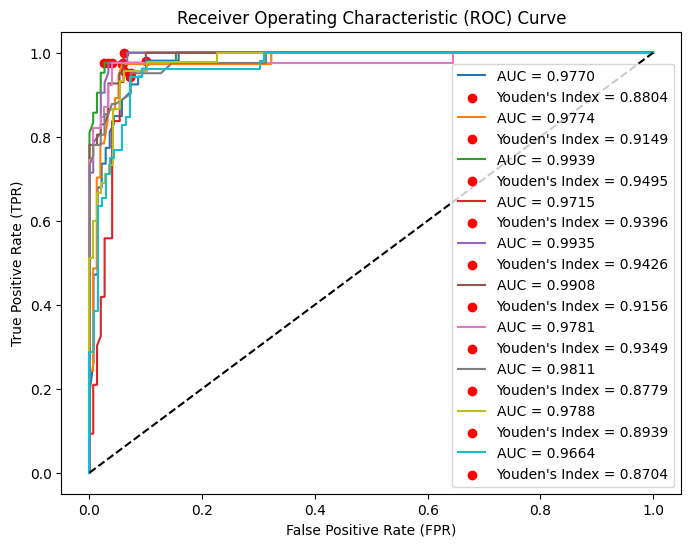

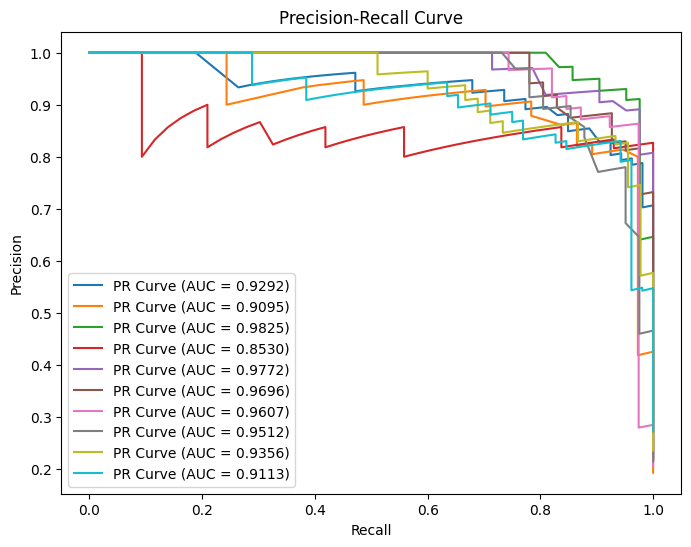

0.9808508111212946
0.8744301532074527


In [18]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('AUC_iter.png')
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('PR_iter.png')
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction BINARY': all_predictions, 'prediction': all_predictions_nonbin})

# Save the DataFrame to a CSV file
results_df.to_csv('LR_iter_pred_rr.csv', index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv('LR_iter.csv')

# Print final Data
print(auc_final)
print(f1_final)